### 01_loading&preprocessing_h5ad 

#### Preprocessing and quality control of SEA-AD single-cell data: 

#### Overview

This iPython notebook works with data from the **Seattle Alzheimer’s Disease Brain Cell Atlas (SEA-AD)**, focusing on single-nucleus RNA sequencing (*snRNA-seq*) from the **middle temporal gyrus (MTG)** of human brains. The dataset includes cells from **both Alzheimer’s disease (AD) patients and controls**.

#### Objectives

- **Load and preprocess the `.h5ad` dataset** from the SEA-AD Atlas.
- **Perform quality control** to filter out low-quality cells, including:
  - Cells with **low gene count** (potentially empty droplets).
  - Cells with **high gene count** (possible multiplets).
  - Cells with **high mitochondrial gene content** (apoptotic cells).
- **Normalize gene expression** for downstream analysis.

#### Required libraries

Before running this notebook, ensure that the following libraries are installed:

```python
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
```

In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define file paths
data_raw_path = "/home/silvanac/NeuroNet_AD/data/raw/whole_taxonomy_MTG_AD.h5ad"

# Save the filtered dataset 
# adata.write(data_processed_path = "/home/silvanac/NeuroNet_AD/data/processed/whole_taxonomy_MTG_AD_processed.h5ad")
# print("Processed file saved in:", data_processed_path)

# Load the file in read mode without loading everything into RAM
adata = sc.read_h5ad(data_raw_path, backed="r")

# View dataset dimensions
print(adata.shape)

(1378211, 36412)


In [3]:
# Extract a sample of 5000 cells for testing
adata_sample = adata[:5000, :].to_memory()

# Verify the new sample
print(adata_sample.shape)

(5000, 36412)


In [8]:
print(adata_sample.var.loc[adata_sample.var["mt"], :])  # Check if there are mitochondrial genes

Empty DataFrame
Columns: [feature_is_filtered, feature_name, feature_reference, feature_biotype, feature_length, feature_type, mt]
Index: []


In [9]:
print(adata_sample.var_names[:100])  # View the first 100 genes and detect the correct prefix


Index(['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001167', 'ENSG00000001460', 'ENSG00000001461',
       'ENSG00000001497', 'ENSG00000001561', 'ENSG00000001617',
       'ENSG00000001626', 'ENSG00000001629', 'ENSG00000001630',
       'ENSG00000001631', 'ENSG00000002016', 'ENSG00000002330',
       'ENSG00000002549', 'ENSG00000002586', 'ENSG00000002587',
       'ENSG00000002726', 'ENSG00000002745', 'ENSG00000002746',
       'ENSG00000002822', 'ENSG00000002834', 'ENSG00000002919',
       'ENSG00000002933', 'ENSG00000003056', 'ENSG00000003096',
       'ENSG00000003137', 'ENSG00000003147', 'ENSG00000003249',
       'ENSG00000003393', 'ENSG00000003400', 'ENSG00000003402',
       'ENSG00000003436', 'ENSG00000003509', 'ENSG00000003756',
       'ENSG00000003987', 'ENSG00000003989', 'ENSG00000004059',
       'ENSG00000004139', 'ENSG000000041

In [10]:
print(adata_sample.var.columns)

Index(['feature_is_filtered', 'feature_name', 'feature_reference',
       'feature_biotype', 'feature_length', 'feature_type', 'mt'],
      dtype='object')


In [11]:
# List of mitochondrial genes in Ensembl (can be expanded with more genes)
mt_gene_list = [
    "ENSG00000198888", "ENSG00000198763", "ENSG00000198899", "ENSG00000198938",
    "ENSG00000228253", "ENSG00000212907", "ENSG00000210082", "ENSG00000198886",
    "ENSG00000210100", "ENSG00000210107", "ENSG00000210112", "ENSG00000210117",
    "ENSG00000210120", "ENSG00000210123", "ENSG00000210125", "ENSG00000210127"
]

# Mark mitochondrial genes in the anndata object
adata_sample.var["mt"] = adata_sample.var_names.isin(mt_gene_list)

# Check how many mitochondrial genes were detected
print(adata_sample.var["mt"].sum())  # Number of detected mitochondrial genes
print(adata_sample.var.loc[adata_sample.var["mt"], :])  # Display mitochondrial genes


7
                 feature_is_filtered feature_name feature_reference  \
ENSG00000198763                False       MT-ND2    NCBITaxon:9606   
ENSG00000198886                False       MT-ND4    NCBITaxon:9606   
ENSG00000198888                False       MT-ND1    NCBITaxon:9606   
ENSG00000198899                False      MT-ATP6    NCBITaxon:9606   
ENSG00000198938                False       MT-CO3    NCBITaxon:9606   
ENSG00000212907                False      MT-ND4L    NCBITaxon:9606   
ENSG00000228253                False      MT-ATP8    NCBITaxon:9606   

                feature_biotype feature_length    feature_type    mt  
ENSG00000198763            gene           1042  protein_coding  True  
ENSG00000198886            gene           1378  protein_coding  True  
ENSG00000198888            gene            956  protein_coding  True  
ENSG00000198899            gene            681  protein_coding  True  
ENSG00000198938            gene            784  protein_coding  True  
ENS

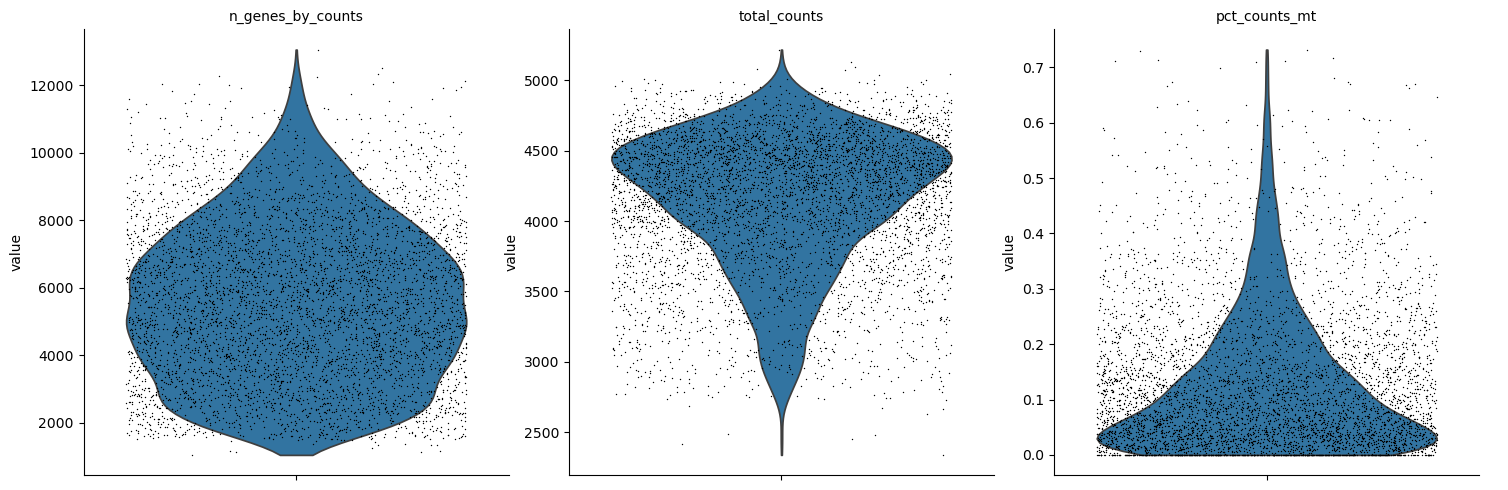

In [12]:
# Calculate the number of mitochondrial genes per cell
mt_counts = adata_sample[:, adata_sample.var["mt"]].X.sum(axis=1)

# Convert to a 1D array if necessary
if isinstance(mt_counts, np.matrix) or len(mt_counts.shape) > 1:
    mt_counts = np.asarray(mt_counts).flatten()

# Calculate the percentage of mitochondrial genes
adata_sample.obs["pct_counts_mt"] = (mt_counts / adata_sample.obs["total_counts"].values) * 100

# Check the distribution
sc.pl.violin(
    adata_sample, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True
)

Number of cells after filtering: 2916


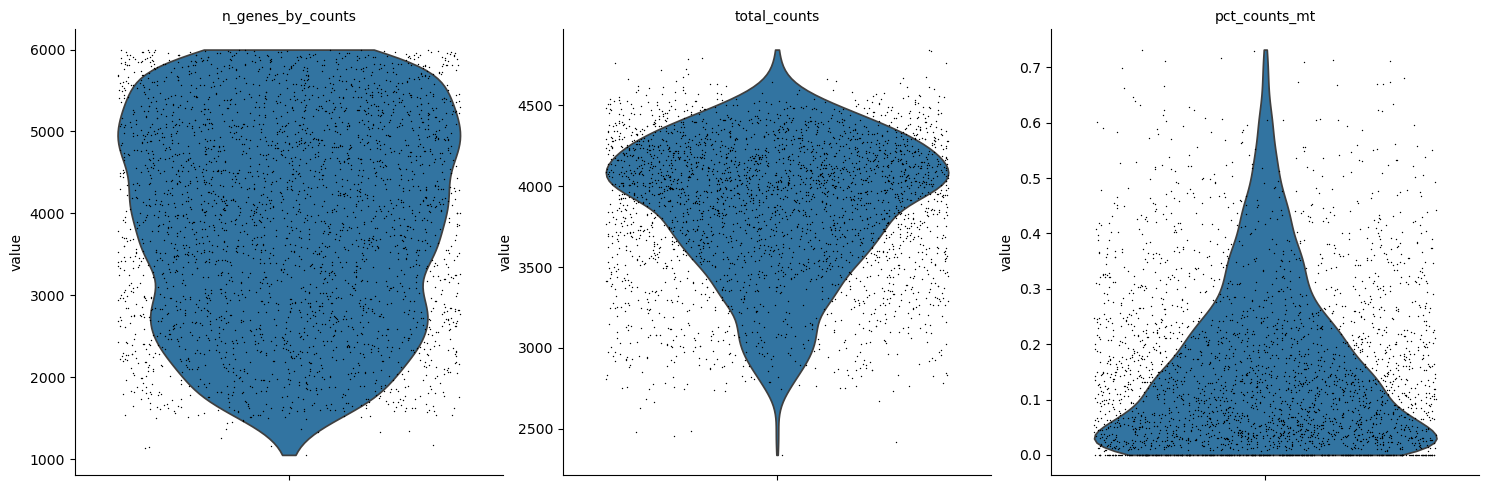

In [13]:
# Define quality thresholds
min_genes = 200      # Filter out cells with fewer than 200 detected genes
max_genes = 6000     # Filter out cells with more than 6000 detected genes
max_mito = 10        # Filter out cells with more than 10% mitochondrial genes

# Apply filtering
adata_sample = adata_sample[
    (adata_sample.obs["n_genes_by_counts"] > min_genes) &
    (adata_sample.obs["n_genes_by_counts"] < max_genes) &
    (adata_sample.obs["pct_counts_mt"] < max_mito)
]

# Check the number of cells after filtering
print(f"Number of cells after filtering: {adata_sample.shape[0]}")

# Visualize quality metrics after filtering
sc.pl.violin(
    adata_sample, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True
)

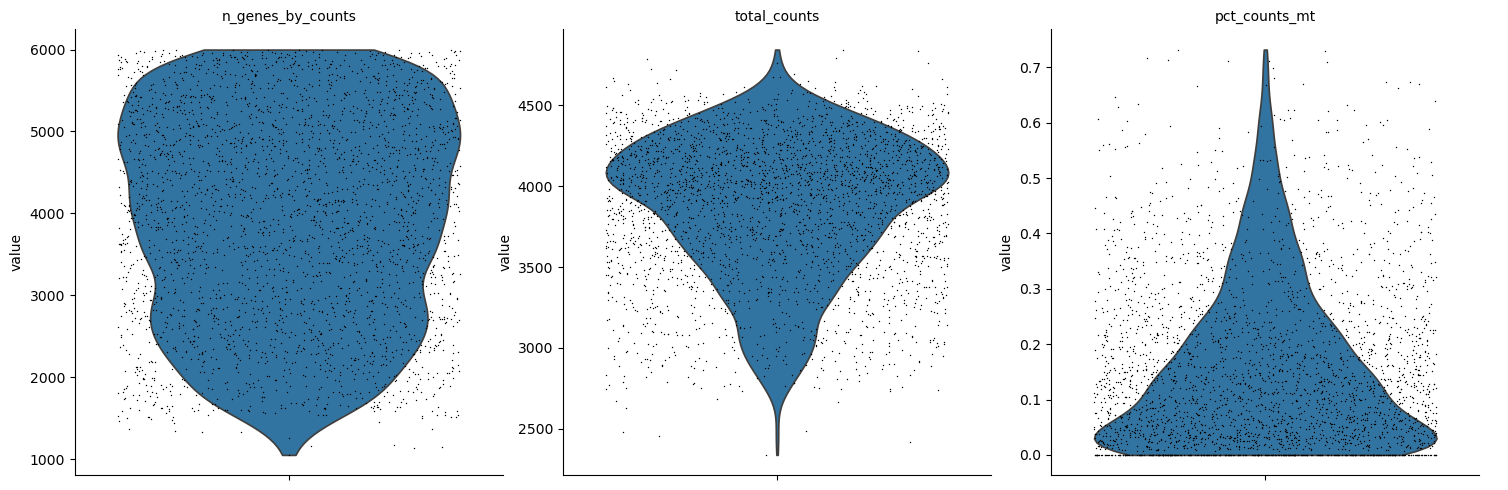

Normalization and logarithmic transformation completed.


In [15]:
# Total normalization
sc.pp.normalize_total(adata_sample, target_sum=1e4)

# Logarithmic transformation
sc.pp.log1p(adata_sample)

# Plot metrics after normalization
sc.pl.violin(
    adata_sample, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True
)

print("Normalization and logarithmic transformation completed.")


In [16]:
import numpy as np

# Check some values from the expression matrix 
print(adata_sample.X[:5, :5])  

# Check for non-integer values (indicating logarithmic transformation)
print("Minimum values in adata.X:", np.min(adata_sample.X))
print("Maximum values in adata.X:", np.max(adata_sample.X))


  (2, 2)	1.0464619398117065
  (2, 3)	0.8301448822021484
  (3, 2)	0.9067816138267517
  (3, 3)	0.9067816138267517
  (3, 4)	0.9067816138267517
  (4, 0)	1.2135061025619507
  (4, 2)	1.2135061025619507
  (4, 4)	1.3879590034484863
Minimum values in adata.X: 0.0
Maximum values in adata.X: 2.6896756


In [17]:
# Normalize without log transformation 
sc.pp.normalize_total(adata_sample, target_sum=1e4, inplace=True)

print("Normalization applied correctly without duplicating log transformation.")


Normalization applied correctly without duplicating log transformation.
